<a href="https://colab.research.google.com/github/bdemchak/cytoscape-jupyter/blob/main/gangsu/basic_protocol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a reproduction of the [Biological Network Exploration with Cytoscape 3](https://pubmed.ncbi.nlm.nih.gov/25199793/) Basic Protocol 2, which imports data from the Goh/Barabasi human disease network and displays it for exploration.

Note that this workflow executes in a Jupyter Notebook that is running on the same workstation as Cytoscape. See [here](https://github.com/bdemchak/cytoscape-jupyter/tree/main/gangsu) for a version of this workflow that executes on a cloud server (e.g., Google Colab).


---
# Setup data files, py4cytoscape and Cytoscape connection
**NOTE: To run this notebook, you must manually start Cytoscape first -- don't proceed until you have started Cytoscape.**


This workflow requires five files that are located in cloud storage:

* disease.net.txt (network file)
* gene.net.txt (network file)
* supplementary_tablesS2.txt (annotation file)
* supplementary_tablesS3.txt (annotation file)
* supplementary_tablesS4.txt (network file)

All files reside in a Github folder, and they are downloaded by this workflow as needed. 

They were originally available from Barabasi Lab, but have since disappeared.


## Setup: Fetch latest py4cytoscape




**Note that you can fetch from the latest Github unreleased version by setting _PY4CYTOSCAPE to 'git+https://github.com/cytoscape/py4cytoscape' immediately before the exec() call. To fetch a particular branch, add '@' to the end (e.g., 'git+https://github.com/cytoscape/py4cytoscape@0.0.11').**

To load the default (PyPI) py4cytoscape version, do not set _PY4CYTOSCAPE at all.

In [1]:
#_PY4CYTOSCAPE = 'git+https://github.com/cytoscape/py4cytoscape@1.6.0' # optional
import requests

exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)

IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cytoscape/py4cytoscape (to revision 1.6.0) to /tmp/pip-req-build-iomu3jzx


  Running command git clone -q https://github.com/cytoscape/py4cytoscape /tmp/pip-req-build-iomu3jzx
  Running command git checkout -b 1.6.0 --track origin/1.6.0
  Switched to a new branch '1.6.0'
  Branch '1.6.0' set up to track remote branch '1.6.0' from 'origin'.


  Created wheel for py4cytoscape: filename=py4cytoscape-1.6.0-py3-none-any.whl size=170728 sha256=c4160194192baa14b0602bb5f56823a87ddffa921806a089bd5b76dd4a0cefa1
  Stored in directory: /tmp/pip-ephem-wheel-cache-nswbjct9/wheels/41/f8/55/7d9713a08400a67188976c9214b7e48e0da9cd32b53ad30109
  Created wheel for python-igraph: filename=python_igraph-0.9.11-py3-none-any.whl size=9074 sha256=42f696dc55c3e1ea023ab926037a7e740b1e1d5e1abec77f527a099f7c515c43
  Stored in directory: /root/.cache/pip/wheels/7d/e4/0c/0c83f70bd0b99ce8aea47a21f8e52502169e7dd17808d12f30
Successfully built py4cytoscape python-igraph
NumExpr defaulting to 2 threads.
Loading Javascript client ... 42335b26-3ae7-493a-a1e0-f54e0b71f266 on https://jupyter-bridge.cytoscape.org
ADVICE: WHEN RUNNING UNDER COLAB, DO NOT RE-RUN THIS CELL WITHOUT MANUALLY EXECUTING Runtime | Factory Reset Runtime FROM THE COLAB MENU FIRST.


<IPython.core.display.Javascript object>

## Setup: Sanity test to verify Cytoscape connection
By now, the connection to Cytoscape should be up and available. To verify this, try a simple operation that doesn't alter the state of Cytoscape.

In [2]:
p4c.cytoscape_version_info()


{'apiVersion': 'v1',
 'automationAPIVersion': '1.6.0',
 'cytoscapeVersion': '3.9.1',
 'jupyterBridgeVersion': '0.0.2',
 'py4cytoscapeVersion': '1.6.0'}

## Setup: Create directories for source data files and output files
Create the 'output' directory, which will be used to store files uploaded from Cytoscape.

This is a good place to prepare any other system resources that might be needed by downstream Notebook cells.

In [3]:
!rm -r Barabasi
!mkdir Barabasi

!rm -r output/
!mkdir output
!ls -l 
OUTPUT_DIR = 'output/'


rm: cannot remove 'Barabasi': No such file or directory
rm: cannot remove 'output/': No such file or directory
total 16
drwxr-xr-x 2 root root 4096 Aug  5 21:42 Barabasi
drwxr-xr-x 2 root root 4096 Aug  5 21:42 logs
drwxr-xr-x 2 root root 4096 Aug  5 21:42 output
drwxr-xr-x 1 root root 4096 Aug  3 20:21 sample_data


## Setup: Import and position network files into Cytoscape's current sandbox



The network and annotation files are in a Github folder, and this cell downloads them into the default Sandbox from where Cytoscape will access them.

The files could just as well have been on any cloud resource, including Google Drive, Dropbox, Microsoft OneDrive or a private web site. Note that if a file would have been too large for GitHub,Dropbox would have been a handy alternative.

An alternative would be to load the files into this Notebook's file system (or create them there) and then download those files to the Sandbox. Loading them into the Notebook file system would require the use of Notebook "!" commands (e.g., !wget).

**Sandboxing is explained in https://py4cytoscape.readthedocs.io/en/latest/concepts.html#sandboxing**

In [4]:
barabasi = {}
barabasi['disease_net_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/disease.net.txt', 'disease.net.txt')
barabasi['gene_net_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/gene.net.txt', 'gene.net.txt')
barabasi['supp_tablesS2_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/supplementary_tableS2.txt', 'supplementary_tableS2.txt')
barabasi['supp_tablesS3_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/supplementary_tableS3.txt', 'supplementary_tableS3.txt')
barabasi['supp_tablesS4_txt'] = p4c.sandbox_url_to('https://github.com/bdemchak/cytoscape-jupyter/blob/main/gangsu/Barabasi/supplementary_tableS4.txt', 'supplementary_tableS4.txt')
for file, desc in barabasi.items():
  print(f"File: {file}, Bytes: {desc['fileByteCount']}, Path: {desc['filePath']}")


File: disease_net_txt, Bytes: 35861, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\disease.net.txt
File: gene_net_txt, Bytes: 197835, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\gene.net.txt
File: supp_tablesS2_txt, Bytes: 97916, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\supplementary_tableS2.txt
File: supp_tablesS3_txt, Bytes: 127626, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\supplementary_tableS3.txt
File: supp_tablesS4_txt, Bytes: 557710, Path: C:\Users\CyDeveloper\CytoscapeConfiguration\filetransfer\default_sandbox\supplementary_tableS4.txt


---
# Explore the protein-protein interaction network

First, load the protein-protein network into Cytoscape.

This could take a few minutes because of the automatic force-directed layout.


In [5]:
p4c.close_session(False)
p4c.import_network_from_tabular_file('supplementary_tableS4.txt', first_row_as_column_names=True, start_load_row=2, column_type_list='x,s,x,t,i')


{'networks': [3102440], 'views': [3220680]}

---
## Layout and overlay information on the network

1.   Create a different colors for the edges representing different types of interactions.
2.   Make the nodes themselves transparent so edges are easier to see.
3.   For fun, create an image of the resulting network and display it in this notebook.

*Tip:* The `notebook_export_show_image()` function exports the current network image to a .PNG file in Cytoscape's sandbox folder (`CytoscapeConfiguration/filetransfer/default_sandbox/image.png`), then uploads it (as `image.png`) to the Notebook file system, and then displays it as Notebook output. You can change the file's name and format by specifying different parameters for this function.


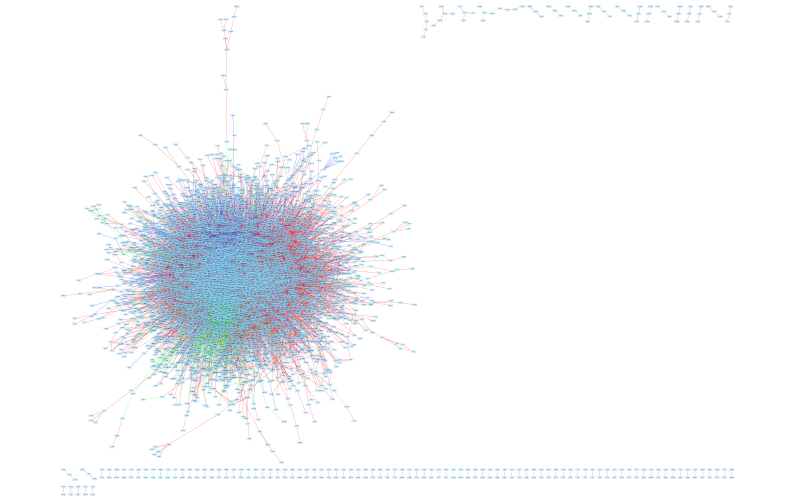

In [6]:
RED = '#ff0000'
GREEN = '#00ff00'
TEAL = '#00ffff'
PURPLE = '#ff00ff'
YELLOW = '#ffff00', 
BLUE = '#0000ff'
GREY = '#808080'

map = p4c.map_visual_property('EDGE_STROKE_UNSELECTED_PAINT', 'interaction', 'discrete', 
                              ['L', 'R', 'RL', 'RS', 'RSL', 'S', 'SL'], 
                              [RED, GREEN, TEAL, PURPLE, YELLOW, BLUE, GREY])
p4c.update_style_mapping('default', map)

p4c.set_node_fill_opacity_default(100, 'default')
p4c.toggle_graphics_details()

p4c.notebook_export_show_image()


---
## Discover local gene clusters using MCODE

Call MCODE to cluster genes using default settings, and then extract the second cluster into a network of its own.

For fun, export the network image and show it in this notebook.

{}


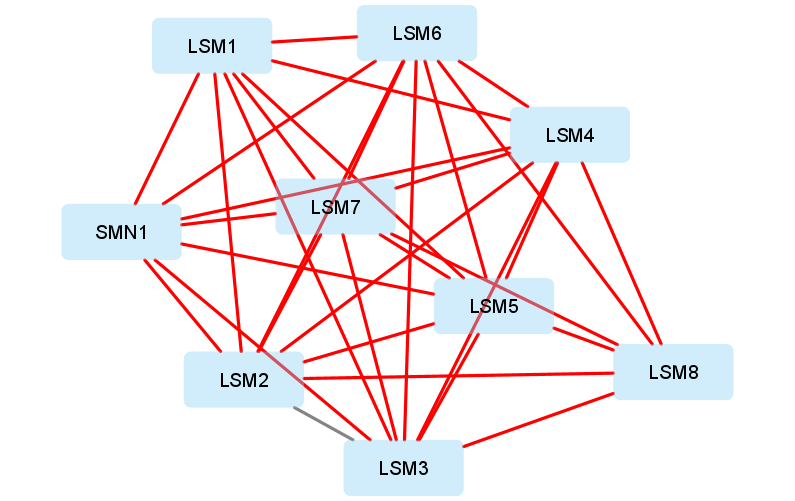

In [7]:
p4c.install_app('MCODE')
p4c.commands_post('mcode cluster network=""')
p4c.commands.commands_post('mcode view id=1 rank=2')

p4c.notebook_export_show_image()

---
# Explore the human disease network

First, load the disease network into Cytoscape, then remove duplicate edges.

Note that the network file is *not* a CSV file -- the separator between values in the file is " ". So, the `import_network_from_tabular_file()` function contains a `delimiter=` parameter to match.

Cytoscape interprets edges in the network file as directional, and many nodes in the disease file are connected by two edges -- one in and one out.

For this demonstration, the directional distinction is meaningless, so we remove in-bound edges that duplicate out-bound edges.

In [8]:
p4c.close_session(False)
res = p4c.import_network_from_tabular_file('disease.net.txt', first_row_as_column_names=True, start_load_row=1, column_type_list='s,t,ea', delimiters=' ')
print(res)

res = p4c.delete_duplicate_edges(ignore_direction=True)
if 'edges' in res:
  print(f'Edges removed: {len(res["edges"])}')
else:
  print('No edges removed')

{'networks': [3345048], 'views': [3356845]}
Edges removed: 1527


## Annotate network with S2 table values

Use Pandas to preprocess the S2 table values, and then load them into Cytoscape as node annotations.

* Use Pandas to parse the data because we need to rename the 'name' column to 'Disease Name' to avoid conflicts with the network's existing 'name' column.

* Once that is done, we can import the annotations into the node table, keyed on the 'Disease ID' column. Note that Pandas would naturally import Disease ID as an int, but we coerce it to str to be compatible with the network's 'name' column.

* Load the Pandas table as annotations to Cytoscape's network.

This is an example of how the workflow can pre-process data that is eventually loaded into Cytoscape.

**Note:** the S2 table file was loaded into the Cytoscape sandbox (on the Cytoscape workstation) earlier in this workflow. Pandas loads files from the Notebook file system, which is different because this workflow is running on a remote server. The `sandbox_get_from()` function copies this file from the sandbox to the Notebook file system so Pandas can read it.

In [9]:
p4c.sandbox_get_from('supplementary_tableS2.txt', 'Barabasi/supplementary_tableS2.txt')

import pandas as df
disease_table = df.read_csv('Barabasi/supplementary_tableS2.txt', sep='\t', header=1, dtype={'Disease ID':str})
disease_table.rename({'Name': 'Disease Name'}, axis=1, inplace=True)
print(disease_table)

p4c.load_table_data(disease_table, data_key_column='Disease ID')

     Disease ID                                       Disease Name  \
0             1                             17,20-lyase_deficiency   
1             3  2-methyl-3-hydroxybutyryl-CoA_dehydrogenase_de...   
2             4                          2-methylbutyrylglycinuria   
3             5  3-beta-hydroxysteroid_dehydrogenase,_type_II,_...   
4             6         3-hydroxyacyl-CoA_dehydrogenase_deficiency   
...         ...                                                ...   
1279       8350                            Combined_SAP_deficiency   
1280       9037                                   Multiple_myeloma   
1281       9038                                 Multiple_sclerosis   
1282       9039                      Multiple_sulfatase_deficiency   
1283       9308                           Renal_tubular_dysgenesis   

     Disorder class  Size (s)  Degree (k)  Class-degree (k)  \
0         Endocrine         1           0                 0   
1         Metabolic         1    

/usr/local/lib/python3.7/dist-packages/py4cytoscape/tables.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


'Success: Data loaded in defaultnode table'

## Search for and select all nodes that have any attribute having to do with Neuro

Create a filter that identifies the term `Neuro` in each description column, then create a composite filter that selects all nodes that match either filter.

**Note:** A Cytoscape user might perform this step by using Cytoscape's search bar, which can be used to find all `Neuro` values in *all* columns. Creating the composite filter approximates this by limiting the search to only two columns: `Disease Name` and `Disorder class`.

In [10]:
p4c.create_column_filter('Find Neuro in Name', 'Disease Name', 'Neuro', 'CONTAINS', apply=False)
p4c.create_column_filter('Find Neuro in class', 'Disorder class', 'Neuro', 'CONTAINS', apply=False)
res = p4c.create_composite_filter('Find Neuro', ['Find Neuro in Name', 'Find Neuro in class'], type='ANY')
print(f'Nodes selected: {len(res["nodes"])}')

No nodes selected.
No edges selected.
No nodes selected.
No edges selected.
No edges selected.
Nodes selected: 86


## Randomly assign colors to each disease

Use the Map Generator feature to identify unique values in the `Disorder class` column, then assign random node colors according to each value. As a result, different disorders have different colors.

In [11]:
p4c.set_node_color_mapping(**p4c.gen_node_color_map('Disorder class', p4c.palette_color_random(), mapping_type='d', style_name='default'))

''

## Create edge widths according to the number of neighbors

Use Map Generator feature to set the width of edges according to the edge Weight attribute. For Weight=1, use a width of 1, and for each higher Weight value, increase the width by 3. As a result, the edge width shows important node connections.

**Note:** To see edge weights in Cytoscape, you may have to zoom the graph display.


In [12]:
p4c.set_edge_line_width_mapping(**p4c.gen_edge_width_map('Weight', 
                                                         p4c.scheme_d_number_series(start_value=1, step=3), 
                                                         mapping_type='d', style_name='default'))

''

## Change node label to be disease name instead of disease number

In [13]:
node_label_map = p4c.map_visual_property('NODE_LABEL', 'Disease Name', 'passthrough')
p4c.update_style_mapping('default', node_label_map)


''

## Set node width and height to be proportional to `Degree (k)` column value

In [14]:
node_height_map = p4c.map_visual_property('NODE_HEIGHT', 'Degree (k)', 'continuous', [1, 50], [30, 300])
p4c.update_style_mapping('default', node_height_map)
node_width_map = p4c.map_visual_property('NODE_WIDTH', 'Degree (k)', 'continuous', [1, 50], [30, 300])
p4c.update_style_mapping('default', node_width_map)

''

---
# Show the resulting network for fun

So far, we have reproduced the visual style used in the [Goh poster](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1885563/bin/pnas_0701361104_9.pdf) for the [2007 Barabasi paper](https://pubmed.ncbi.nlm.nih.gov/17502601/) on human disease. 

For fun, we'll clean up the network by removing disconnected sub-networks and showing the result in this notebook.

## Toss all disconnected sub-networks

We start by identifying a node in the main network ... I chose node 812, which is Insomnia. To select the network containing 812, we use the `Largest Subnetwork` app, which has a function that selects the network containing 812, leaving the unconnected nodes unselected.

Next, we delete the disconnected nodes and re-size the network to fill the drawing space.

**Note:** This cell demonstrates how to use a Cytoscape app to perform useful utility functions. The `Largest Subnetwork` app is callable because it supports Cytoscape Automation.

{}
Count of nodes selected: 516


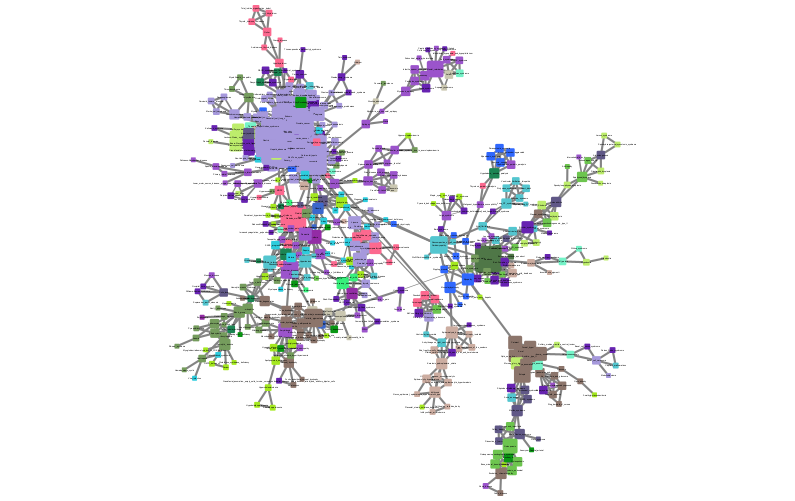

In [15]:
p4c.install_app('Largest Subnetwork')
res = p4c.commands_post('network select subnetwork createSubnetwork=false includesNode=812')
print(f'Count of nodes selected: {len(res["nodes"])}')

p4c.invert_node_selection()
p4c.delete_selected_nodes()
p4c.fit_content()

p4c.notebook_export_show_image()

## Upload the network in vector format

While a network in PNG format is easy to display on a web page, it's hard to see detail by zooming in, particularly this network. Upload the network in PDF format so it can be better zoomed in a PDF viewer. (The PNG format is a raster format, which means it doesn't scale when zoomed. PDF is a vector format, which does scale when zoomed.)

Use your browser to download Disease.pdf from your Colab workspace, then open it using your workstation's PDF viewer. Zooming will show node labels to be crisp and readable.

*Tip:* The `export_image()` function exports the current network image to a .PDF file in Cytoscape's sandbox folder (`CytoscapeConfiguration/filetransfer/default_sandbox/Disease.pdf`).The `sandbox_get_from()` function then uploads it (as `Disease.pdf`) to the Notebook file system. You can choose to view the PDF file on the Cytoscape workstation by loading the sandbox version.

*Tip:* You can also change the resolution, height, width and zoom by setting parameters in the `export_image()` function.

In [16]:
OUT_FILE = 'Disease.pdf'
p4c.export_image(OUT_FILE, type='PDF', overwrite_file=True)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')


{'fileByteCount': 71021,
 'filePath': 'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\Disease.pdf',
 'modifiedTime': '2022-08-05 14:46:33.0310'}